Fig. 5: Benchmarking (Palantir)
----
Runs Palantir and visualizes identified terminal states, fate bias and gene expression trends. Also computes MAGIC imputed data and Palantir pseudotime used in other notebooks. 

# Preliminaries

## Import packages

In [1]:
# import standard packages
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

# import single-cell packages
import scanpy as sc
import scanpy.external as sce
import scvelo as scv
import cellrank as cr

# utilities used to transfer data to cellrank for plotting
from cellrank.tl import Lineage
from cellrank.tl._utils import _fuzzy_to_discrete, _series_from_one_hot_matrix
from cellrank.tl._colors import _colors_in_order

# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 2
scv.settings.verbosity = 3 

## Print package versions for reproducibility

If you want to exactly reproduce the results shown here, please make sure that your package versions match what is printed below. 

In [2]:
cr.logging.print_versions()

cellrank==1.5.0+g65f1562 scanpy==1.8.1 anndata==0.7.6 numpy==1.20.3 numba==0.54.0 scipy==1.7.1 pandas==1.3.3 pygpcca==1.0.2 scikit-learn==0.24.2 statsmodels==0.13.0rc0 python-igraph==0.9.1 scvelo==0.2.4 pygam==0.8.0 matplotlib==3.4.3 seaborn==0.11.2


In [3]:
cr.logging.print_version_and_date()

Running CellRank 1.5.0+g65f1562, on 2021-11-04 22:05.


## Set up paths

Define the paths to load data, cache results and write figure panels.

In [4]:
sys.path.insert(0, "../../../")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, CACHE_DIR, FIG_DIR

Set up the paths to save figures.

In [5]:
scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)
cr.settings.figdir = str(FIG_DIR)

## Set up caching

Note: we use a caching extension called `scachepy` for this analysis, see [here](https://github.com/theislab/scachepy). We do this to speed up the runtime of this notebook by avoiding the most expensive computations. Below, we check whether you have scachepy installed and if you don't, then we automatically recompute all results. 

In [6]:
try:
    import scachepy
    c = scachepy.Cache(CACHE_DIR / "benchmarking" / "palantir", separate_dirs=True)
except ImportError:
    c = None
    print('Failed to import scachepy. Consider installing it from `https://github.com/theislab/scachepy`. ')
use_caching = c is not None
c

Cache(root=/Users/marius/Projects/cellrank_reproducibility_2/cache/benchmarking/palantir, ext='.pickle', compression='None')

## Set global parameters

Set some plotting parameters.

In [7]:
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=25, color_map='viridis')
scv.settings.plot_prefix = ""

Set other global parameters

In [8]:
# should figures just be displayed or also saved?
save_figure = True

# should cashed values be used, or recompute?
force_recompute = False

# whether to write Palantir's pseudotime and MAGIC imputed data
write_data = False

# whether to recompute Palantir's waypoint cells
write_waypoints = False
recompute_waypoints = False

Set Palantir parameters

In [9]:
knn=30
num_waypoints=1200
n_jobs=-1
scale_components=False

## Define utility functions

The below function to plot gene trends is copied from Palantir with slight modifications. 

In [10]:
# directly taken from Palantir with slight modifications
def plot_gene_trends(gene_trends, genes, color_mapper, figsize=None):
    """ Plot the gene trends: each gene is plotted in a different panel
    :param: gene_trends: Results of the compute_marker_trends function
    """
    # Branches and genes
    branches = list(gene_trends.keys())
    if genes is None:
        genes = gene_trends[branches[0]]["trends"].index

    # Set up figure
    if figsize is None:
        figsize = len(genes), 13
    fig, axes = plt.subplots(figsize=figsize, nrows=len(genes), sharex='col')
    axes = np.array(axes).reshape((-1,))
    fig.tight_layout()
    
    for i, (gene, ax) in enumerate(zip(genes, axes)):
        for branch in branches:
            trends = gene_trends[branch]["trends"]
            stds = gene_trends[branch]["std"]
            ax.plot(
                trends.columns, trends.loc[gene, :], color=color_mapper[branch], label=branch
            )
            ax.fill_between(
                trends.columns,
                trends.loc[gene, :] - stds.loc[gene, :],
                trends.loc[gene, :] + stds.loc[gene, :],
                alpha=0.1,
                color=color_mapper[branch],
            )
            ax.set_ylabel(gene)

    ax.set_xticks([0, 1])
    sns.despine()
    
    return fig

Define linege names, the gene names we're interested in and the colors we use thoughout this manuscript. 

In [11]:
lineages = ['Alpha', 'Beta', 'Epsilon', 'Delta']
colors = ['#1f78b4', '#b2df8a', '#cab2d6', '#6a3d9a']
genes = ['Pax4', 'Pdx1', 'Arx', 'Peg10',
         'Irs4', 'Ghrl', 'Hhex', 'Cd24a']
color_mapper = dict(zip(lineages, colors))

## Load the data

Load the AnnData object from the CellRank software package. 

In [12]:
adata = cr.datasets.pancreas(DATA_DIR / "pancreas" / "pancreas.h5ad")
adata

AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

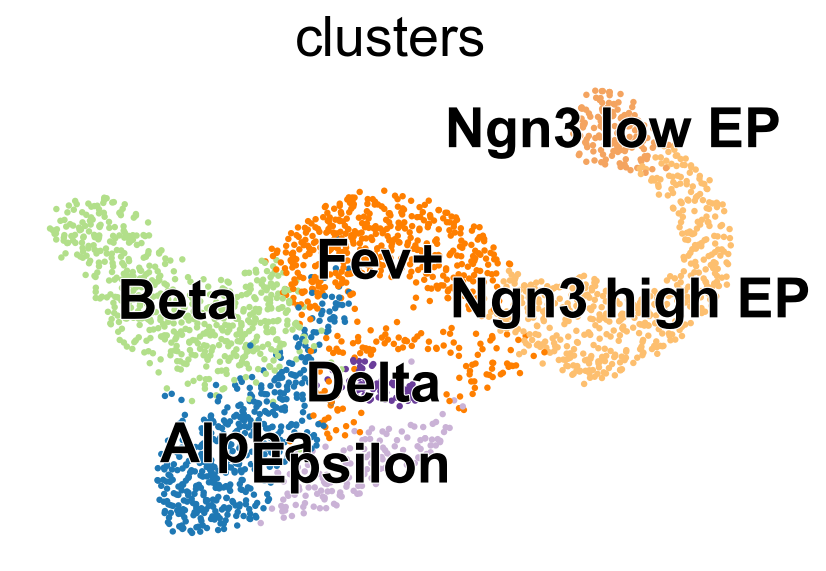

In [13]:
scv.pl.scatter(adata)

# Prepare for Palantir

In [14]:
import palantir
print(f"palantir=={palantir.__version__}")

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


palantir==1.0.0


## Pre-process the data

Basic gene filtering and normalization

In [15]:
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=1500)

filtered out 15011 genes that are detected in less than 10 cells
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)


## Compute PCA, Diffmap and Multiscale data

Compute PCA representation and Diffmap

In [16]:
sc.pp.pca(adata, use_highly_variable=True, n_comps=500)
n_comps = np.where(np.cumsum(adata.uns['pca']['variance_ratio']) > 0.85)[0][0]
print(f"This selects {n_comps} PCs. ")
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(adata.obsm['X_pca'][:, :n_comps], index=adata.obs_names))

computing PCA
    on highly variable genes
    with n_comps=500
    finished (0:00:03)
This selects 403 PCs. 
Determing nearest neighbor graph...
computing neighbors
    finished (0:00:02)


Use the diffusion components to construct a denoised KNN graph and data representation:

In [17]:
# comptue multiscale space in diffusion map space
ms_data = palantir.utils.determine_multiscale_space(dm_res)
ms_data.shape

(2531, 8)

## Visualise multiscale data

Visualise multiscale components in the UMAP

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


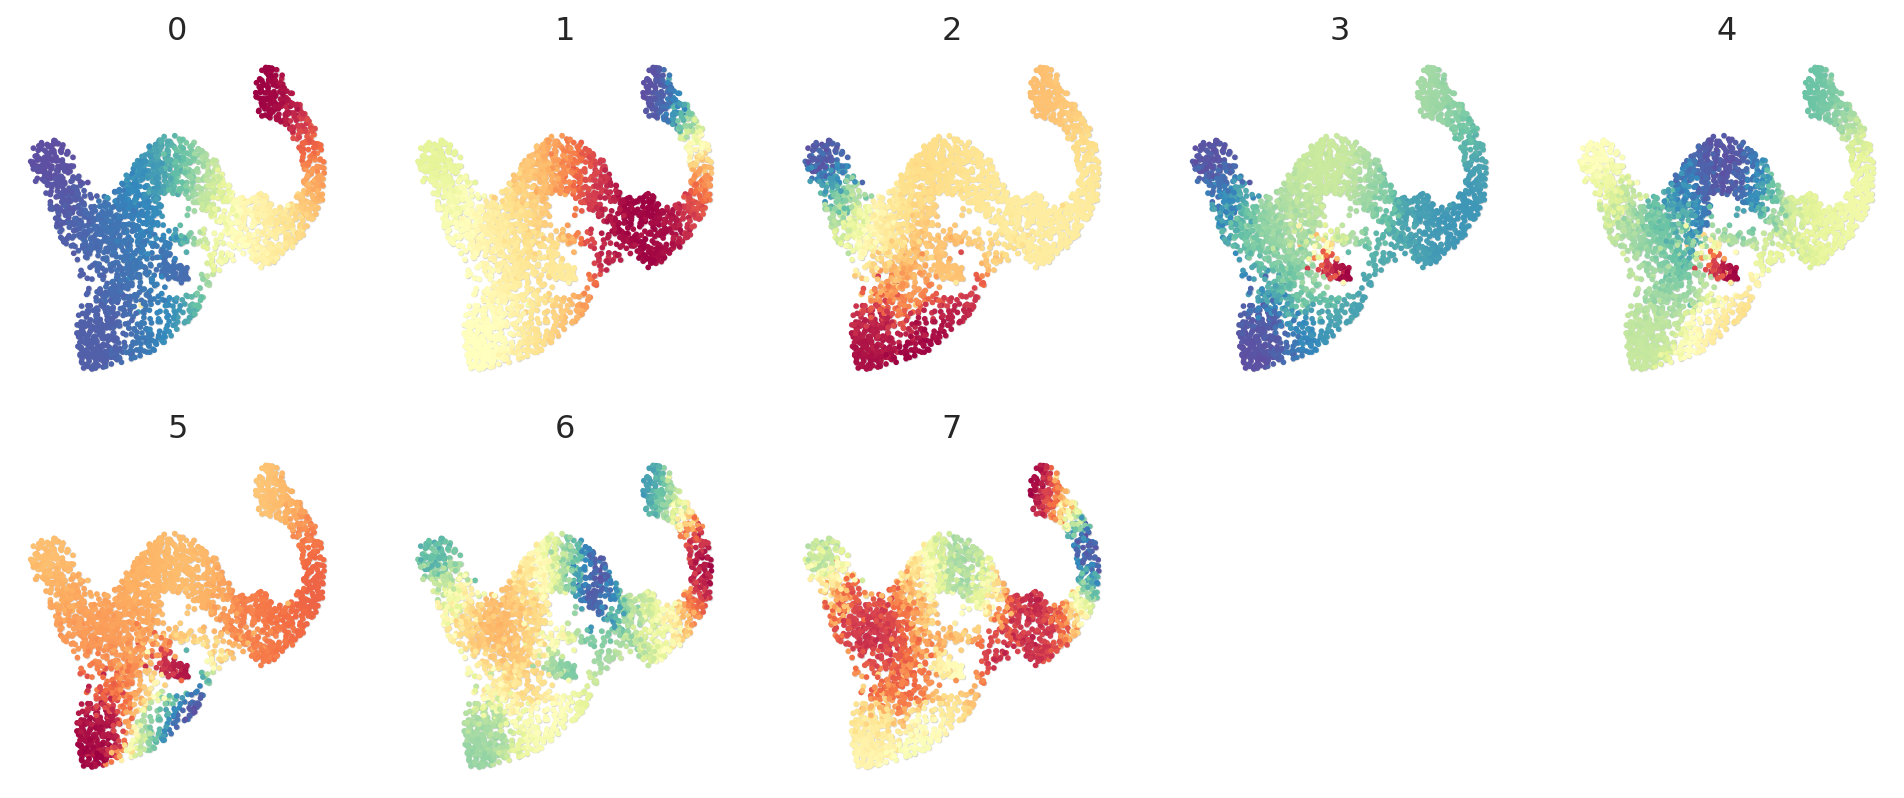

In [18]:
umap = pd.DataFrame(adata.obsm['X_umap'], index=adata.obs_names, columns=['x', 'y'])
palantir.plot.plot_gene_expression(ms_data, umap, ms_data.columns)

## Define an initial cell

We know from CellRank that the initial state is given by the Ngn3 low EP cells. We pass one of them as an initial cell to Palantir:

CGGACTGCAGCCAATT-1-3


(<Figure size 320x320 with 1 Axes>, <AxesSubplot:>)

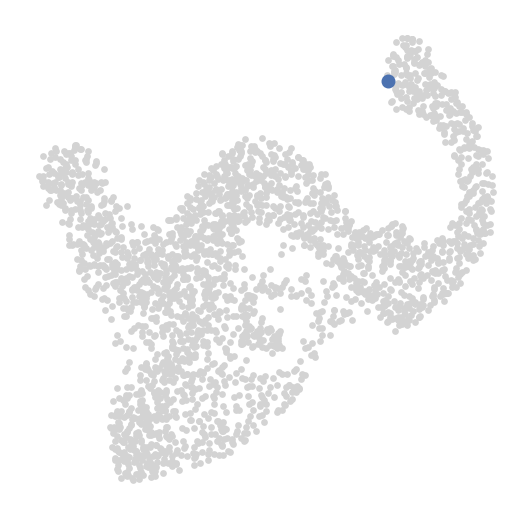

In [19]:
print(ms_data[0].idxmin())
root_cell = 'TGCTACCCAGGGCATA-1-3'
palantir.plot.highlight_cells_on_tsne(umap, root_cell)

# Run Palantir

## Run Palantir without terminal states

In [20]:
pr_res = palantir.core.run_palantir(ms_data, 
                                    root_cell, 
                                    terminal_states=None,
                                    knn=knn, 
                                    num_waypoints=num_waypoints, 
                                    n_jobs=n_jobs,
                                    scale_components=scale_components, 
                                    use_early_cell_as_start=True)

Sampling and flocking waypoints...
Time for determining waypoints: 0.0038052837053934732 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.09524463415145874 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


Give the terminal populations nicer names:

In [21]:
pr_res.branch_probs.columns = ['Beta', 'Delta' ]

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


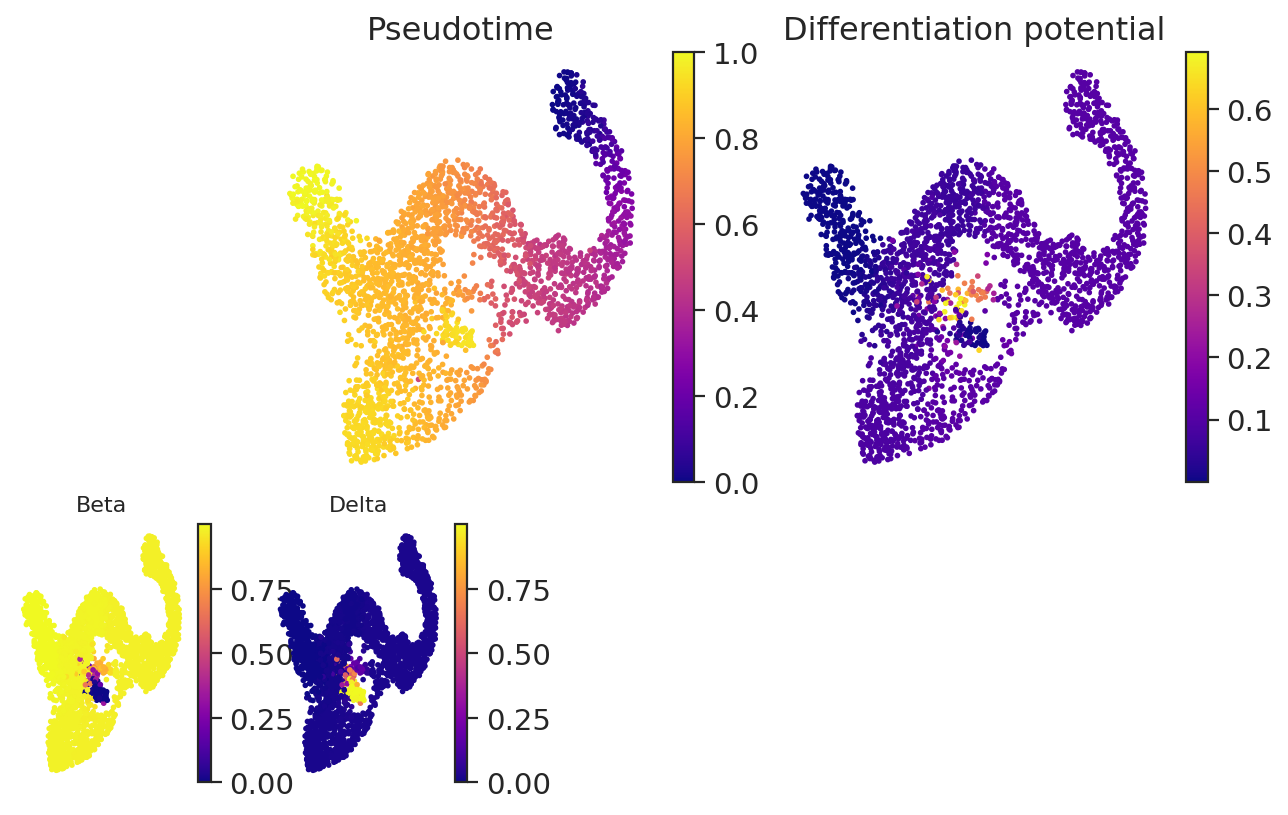

In [22]:
palantir.plot.plot_palantir_results(pr_res, umap)

Get the most likely cells from each branch, map colors and plot

In [23]:
# put branch probs into lineag object
X = pr_res.branch_probs
names = X.columns
colors = _colors_in_order(adata, clusters=names)
L = Lineage(X.values, names=names, colors=colors)

# celect most likely cells per branch, save in adata
D, _ = _fuzzy_to_discrete(L, n_most_likely=30, check_row_sums=False)
adata.obs['terminal_states'] = _series_from_one_hot_matrix(D, index=adata.obs_names, names=L.names)
adata.uns['terminal_states_colors'] = L.colors

# plot
scv.pl.scatter(adata, color='terminal_states',
               save=scv.settings.figdir + "/fig_5_benchmarking/palantir/terminal_states.pdf" if save_figure else None)

saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/fig_5_benchmarking/palantir/terminal_states.pdf


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/scvelo/plotting/utils.py:1009: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


## Run Palantir with terminal states

### Pass the terminal state information

We know form CellRank where ther terminal states are located, so we can easily pass these to Palantir based on the multiscale components here:

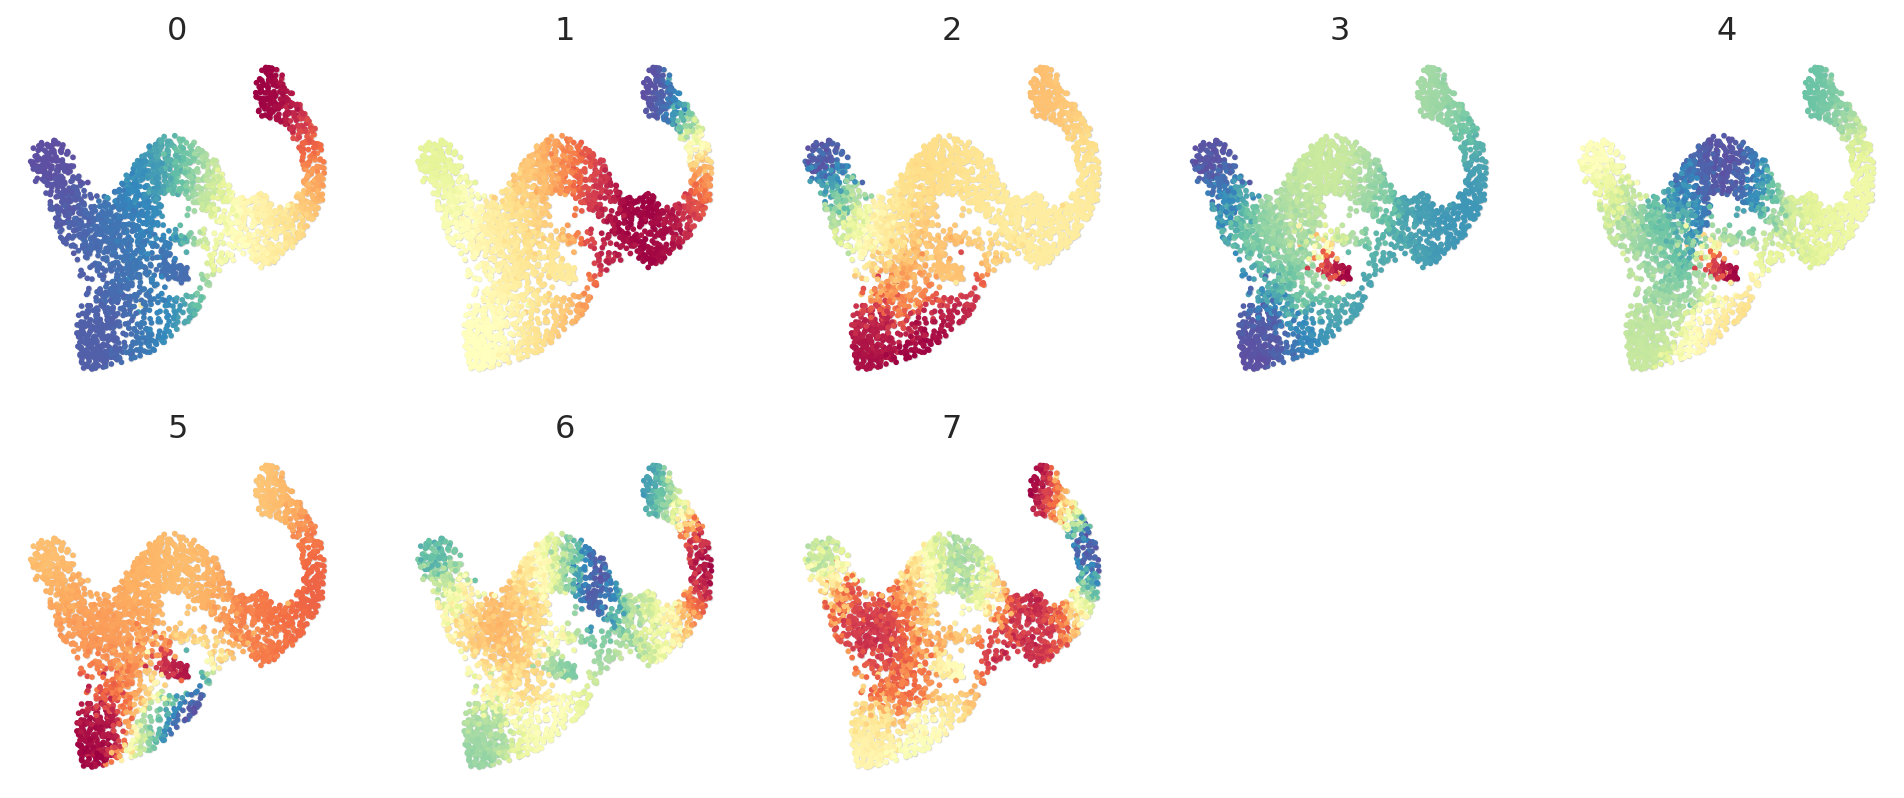

In [24]:
palantir.plot.plot_gene_expression(ms_data, umap, ms_data.columns)

(<Figure size 320x320 with 1 Axes>, <AxesSubplot:>)

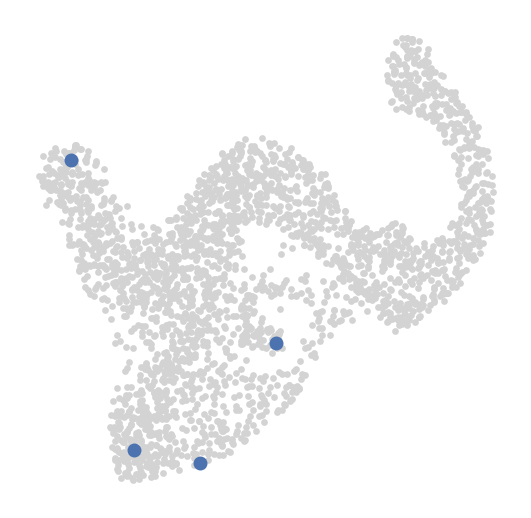

In [25]:
# Alpha: ms_data[5].idxmax()
# Epsilon: ms_data[2].idxmin()
# Beta: ms_data[2].idxmax()
# Delta: ms_data[3].idxmax()

terminal_cells = {
    'Alpha': 'CCACCTATCGGAAACG-1-3', 
    'Epsilon': 'TAAGCGTGTTTGGGCC-1-3', 
    'Beta': 'CGGACTGCAGCCAATT-1-3',
    'Delta': 'AGTGTCACATAGTAAG-1-3'
}
palantir.plot.highlight_cells_on_tsne(umap, terminal_cells.values())

### Run Palantir with these terminal states

Palantir has an element of randomness in selecting the waypoint cells. We tried to eleminate this by passing the random seed but it doesn't seem to be propagated all the way to where it needs to be. For this reason, we manually eleminate this randomness by wiring the waypoint cells to file. 

In [26]:
import random
random.seed = 0
np.random.seed(0)

if not recompute_waypoints:
    waypoints = pd.Index(pd.read_csv(DATA_DIR / "benchmarking" / "palantir" / "ML_2021-11-04_waypoints.csv", index_col=0)["0"]) 

pr_res = palantir.core.run_palantir(ms_data, 
                                    root_cell, 
                                    terminal_states=terminal_cells.values(),
                                    knn=knn, 
                                    num_waypoints=num_waypoints if recompute_waypoints else waypoints, 
                                    n_jobs=n_jobs,
                                    scale_components=scale_components,
                                    use_early_cell_as_start=True)

if write_waypoints:
    pd.Series(pr_res.waypoints).to_csv(DATA_DIR / "benchmarking" / "palantir" / "waypoints.csv")

Sampling and flocking waypoints...
Time for determining waypoints: 2.6365121205647785e-05 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.03831963141759236 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


Give the branches nice names:

In [27]:
terminal_cells_inverse = {value: key for key, value in terminal_cells.items()}
pr_res.branch_probs.columns = [terminal_cells_inverse[key] for key in pr_res.branch_probs.columns]
pr_res.branch_probs.head()

,Delta,Alpha,Beta,Epsilon
index,,,,
AAACCTGAGAGGGATA-1-3,0.000000,0.275699,0.672462,0.044501
AAACCTGAGGCAATTA-1-3,0.000000,0.274670,0.673641,0.044403
AAACCTGGTAAGTGGC-1-3,0.010273,0.270477,0.615216,0.104034
AAACCTGTCCCTCTTT-1-3,0.000000,0.955357,0.017969,0.026162
AAACGGGAGTAGCGGT-1-3,0.999344,0.000000,0.000000,0.000000


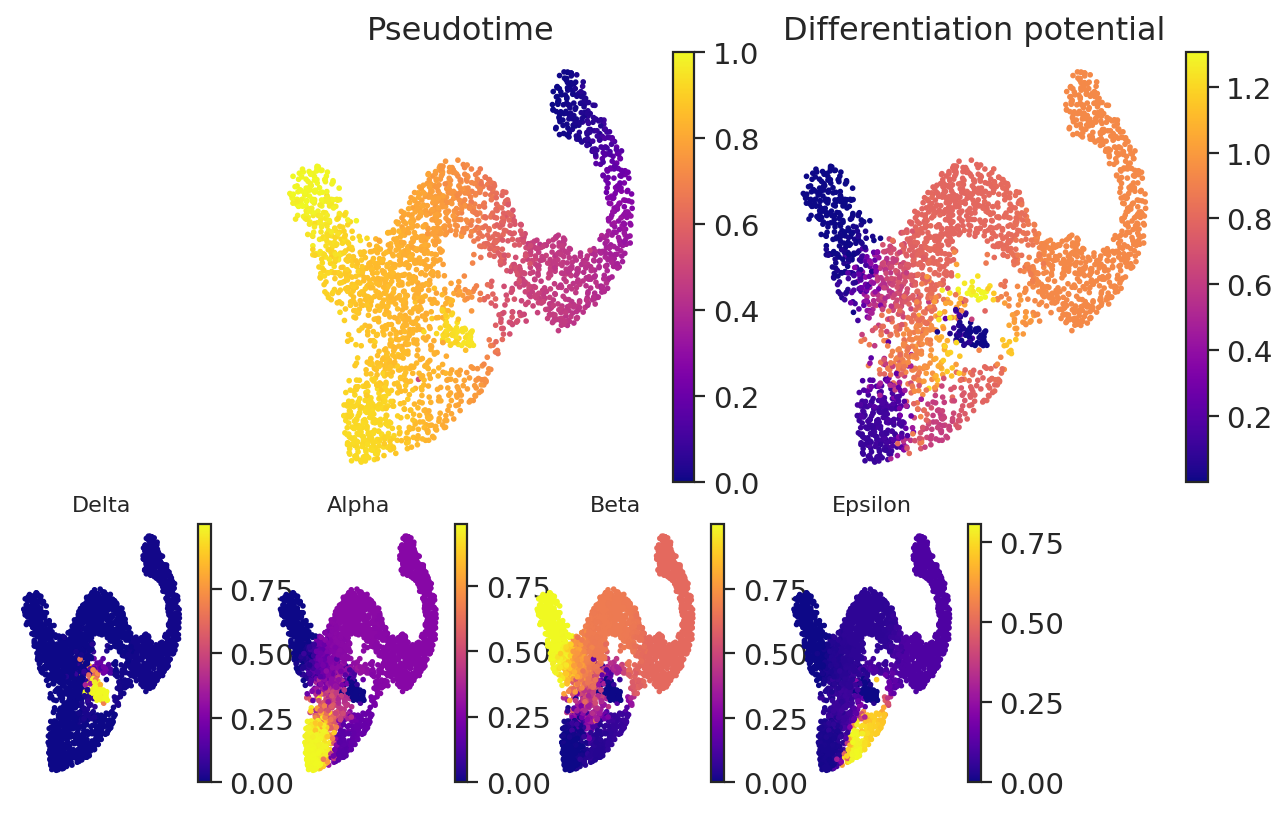

In [28]:
palantir.plot.plot_palantir_results(pr_res, umap)

## Run MAGIC

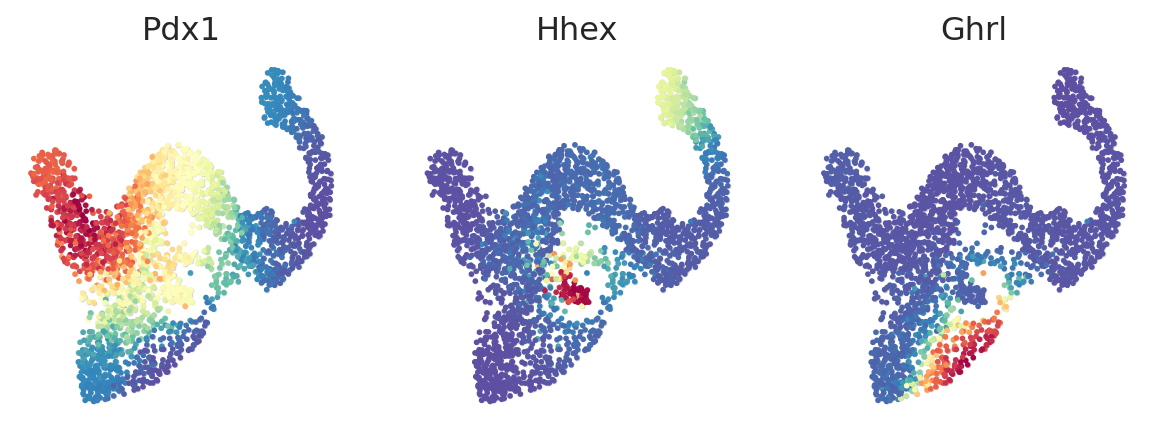

In [29]:
imp_df = palantir.utils.run_magic_imputation(adata, dm_res)
palantir.plot.plot_gene_expression(imp_df, umap, ['Pdx1', 'Hhex', 'Ghrl'])

## Plot gene expression trends

In [30]:
gene_trends = palantir.presults.compute_gene_trends(pr_res, imp_df.loc[:, genes],
                                                    n_jobs=1)

Delta
Time for processing Delta: 0.023309560616811116 minutes
Alpha
Time for processing Alpha: 0.026205535729726157 minutes
Beta
Time for processing Beta: 0.02542190154393514 minutes
Epsilon
Time for processing Epsilon: 0.02685474952061971 minutes


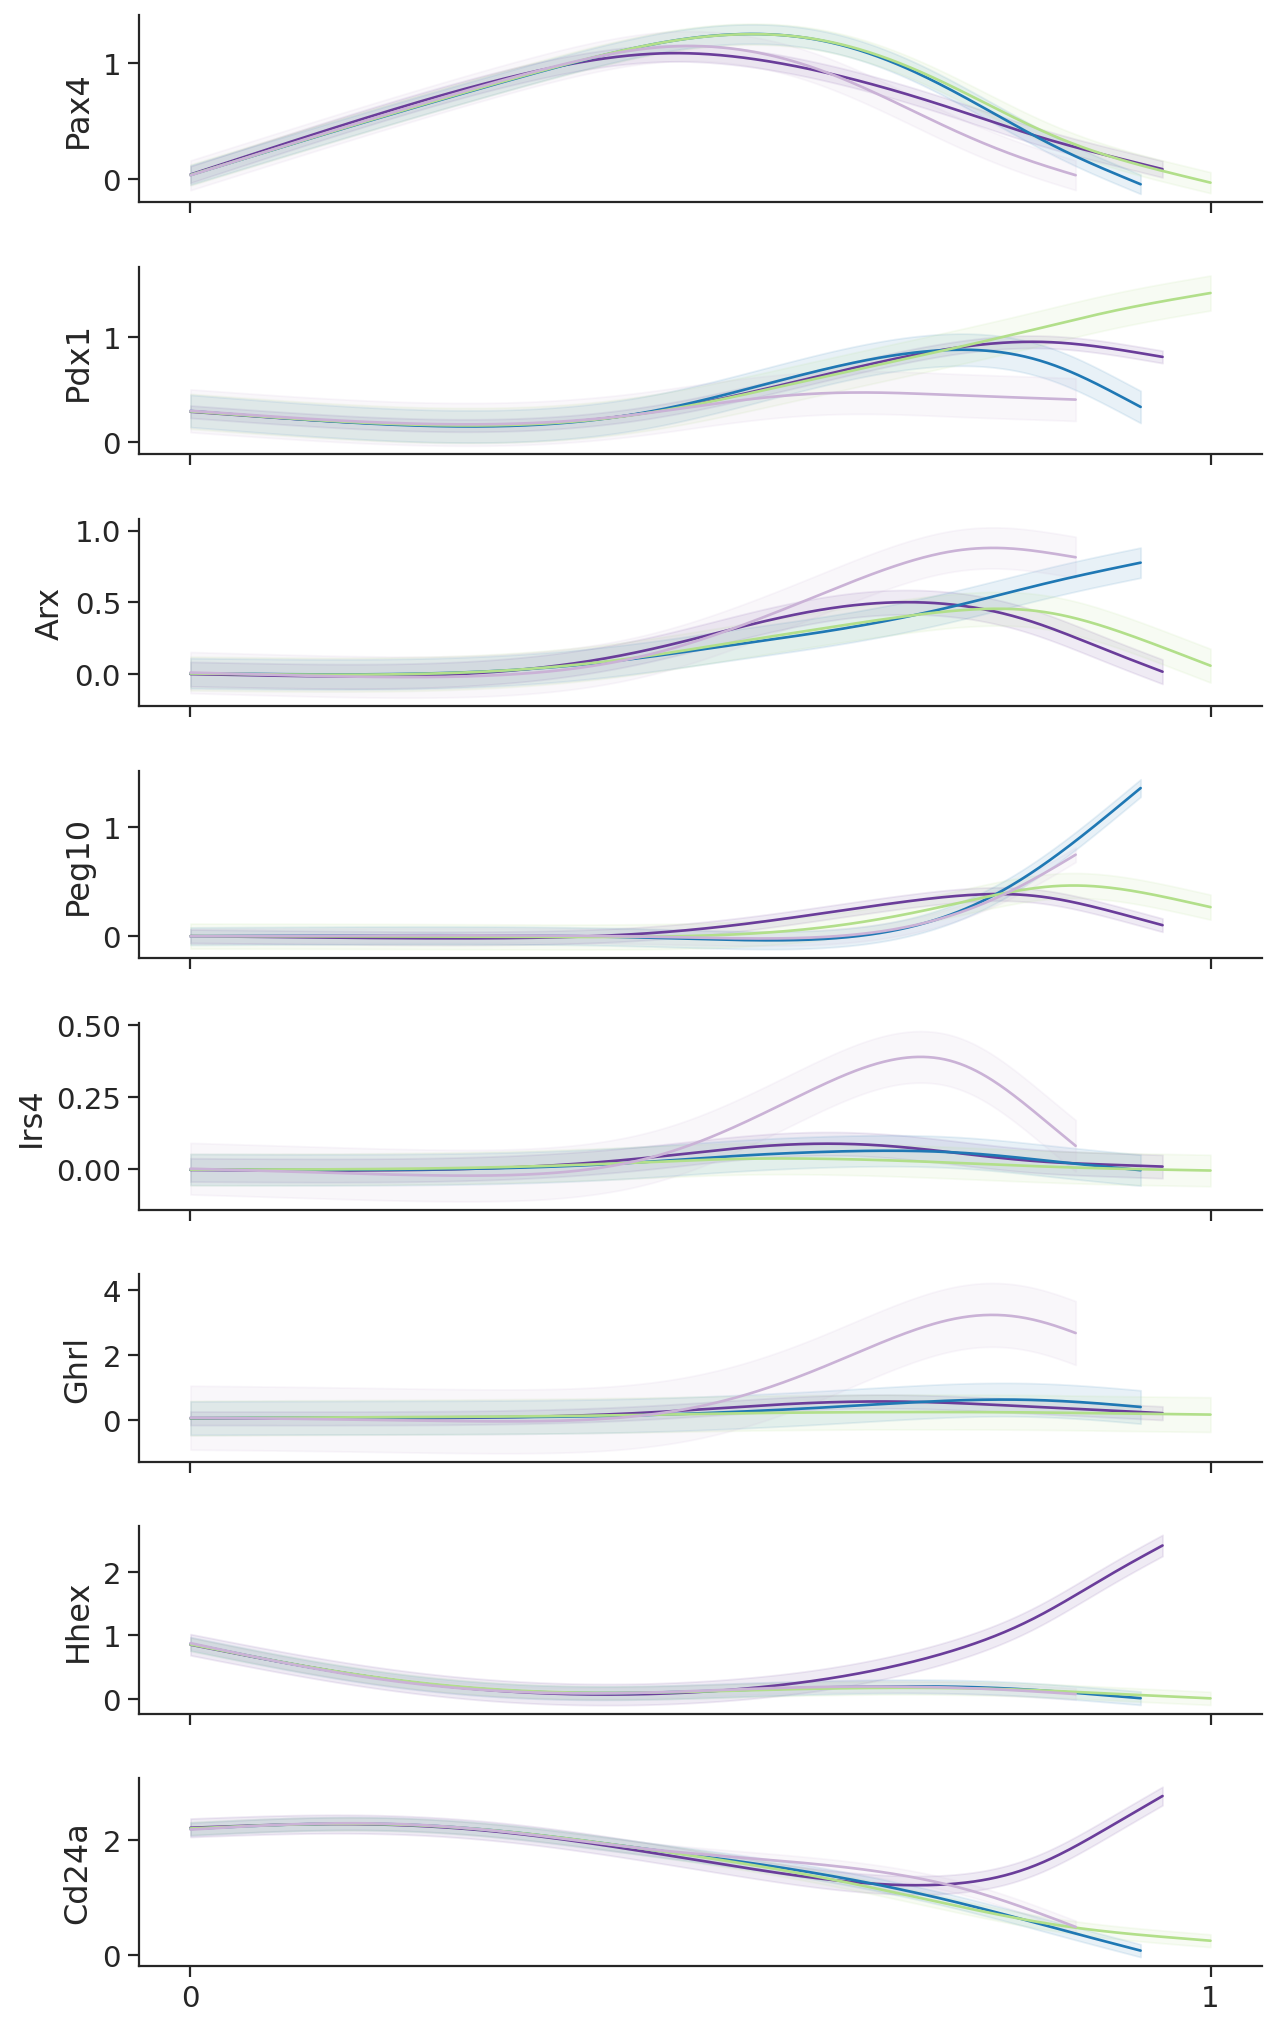

In [31]:
f = plot_gene_trends(gene_trends, genes, color_mapper)
if save_figure:
    f.savefig(FIG_DIR / "suppl_figures_gene_trends" / "palantir.pdf", 
              transparent=True, bbox_inches='tight')

In [32]:
gene_trends = palantir.presults.compute_gene_trends(pr_res, imp_df.loc[:, ['Pdx1']],
                                                    n_jobs=1)

Delta
Time for processing Delta: 0.003159650166829427 minutes
Alpha
Time for processing Alpha: 0.0035052140553792316 minutes
Beta
Time for processing Beta: 0.0032199780146280927 minutes
Epsilon
Time for processing Epsilon: 0.0034279624621073404 minutes


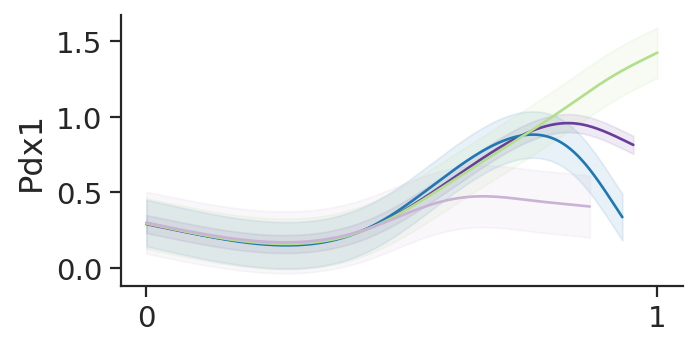

In [33]:
f = plot_gene_trends(gene_trends, ['Pdx1'], color_mapper, figsize=(4.5, 2.5))
if save_figure:
    f.savefig(FIG_DIR / "fig_5_benchmarking" / "palantir" / "gene_trend_pdx1.pdf", 
              transparent=True, bbox_inches='tight',)

# Visualize fate probabilities in CellRank

This last part is just about plotting fate probabilities, which is a bit easier to do in CellRank. For this reason, we interface Palantir results back into an AnnData object. 

## Construct an AnnData object

In [34]:
# create a lineage object for the branch probabilities
X = pr_res.branch_probs
names = X.columns
colors = _colors_in_order(adata, clusters=names)
L = Lineage(X.values, names=names, colors=colors)
adata.obsm['to_terminal_states'] = L

# Create final states annotation
D, _ = _fuzzy_to_discrete(L, n_most_likely=30, check_row_sums=False)
adata.obs['terminal_states'] = _series_from_one_hot_matrix(D, index=adata.obs_names, names=L.names)
adata.uns['terminal_states_colors'] = L.colors
adata.uns['to_terminal_states_colors'] = L.colors

# save the pseudotime
adata.obs['palantir_pseudotime'] = pr_res.pseudotime.copy()

# save the imputed data
adata.layers['magic_imputed_data'] = imp_df.values

Change the plotting parameters

In [35]:
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')

## Plot fate probabilities

In [36]:
fig_kwargs = {'title': 'cell fate map', 'dpi': 150,
             'color': 'terminal_states', 'color_gradients': 'to_terminal_states'}
if save_figure: fig_kwargs['save'] = scv.settings.figdir + 'fig_5_benchmarking/palantir/fate_probs.pdf'
scv.pl.scatter(adata,  **fig_kwargs)

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/fig_5_benchmarking/palantir/fate_probs.pdf


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/scvelo/plotting/utils.py:1009: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


## Plot average fates

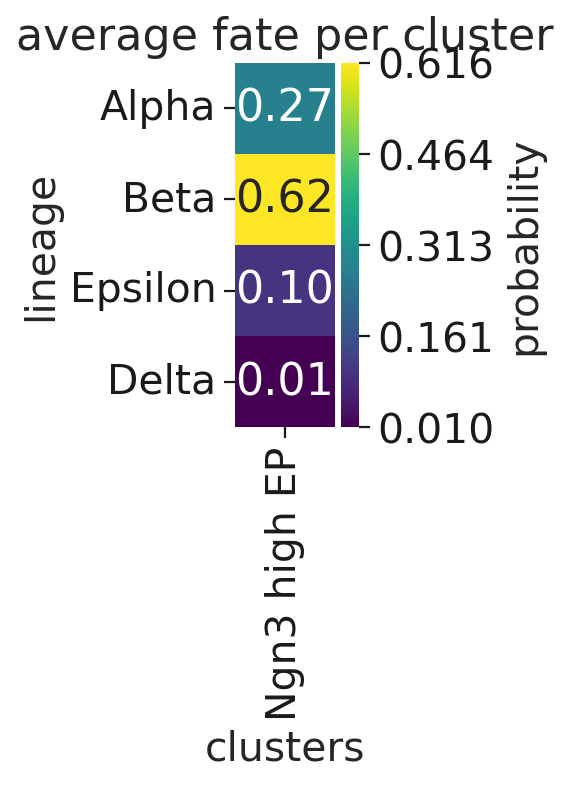

In [37]:
fig_kwargs = {'cluster_key': 'clusters', 
                 'mode': 'heatmap', 
                 'lineages': ['Alpha', 'Beta', 'Epsilon', 'Delta'],
                 'clusters': ['Ngn3 high EP'], 
                 'figsize': (1, 3), 
                 }
if save_figure: fig_kwargs['save'] = 'fig_5_benchmarking/palantir/average_ngn3_fate.pdf'
cr.pl.cluster_fates(adata, **fig_kwargs)

## Plot the Palantir pseudotime

In [38]:
scv.pl.scatter(adata, c=["palantir_pseudotime"], color_map="viridis", 
               save=scv.settings.figdir + 'suppl_figures_pancreas/suppl_fig_palantir_pseudotime/pseudotime.pdf')

saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/suppl_figures_pancreas/suppl_fig_palantir_pseudotime/pseudotime.pdf


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/scvelo/plotting/utils.py:1009: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


## Write MAGIC data and Palantir's pseudotime

In [39]:
if write_data:
    palantir_pseudotime = sc.get.obs_df(adata, keys=["palantir_pseudotime"])
    magic_imputed_data = pd.DataFrame(data=adata.layers['magic_imputed_data'], 
                                      index=adata.obs_names, columns=adata.var_names)
    palantir_pseudotime.to_csv(DATA_DIR / "pancreas" / "pancreas_palantir_pseudotime.csv")
    magic_imputed_data.to_csv(DATA_DIR / "pancreas" / "pancreas_magic_imputed_data.csv")